## LDA Approximation in the 1nn case

#### Imports

In [3]:
import numpy as np
from src.utils_nambu_system import parallel_nambu_diagonalization_ising_model
import matplotlib.pyplot as plt

#### Data

100%|██████████| 100/100 [00:00<00:00, 141.67it/s]


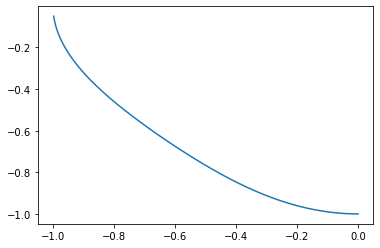

In [16]:
hmax=10
ndata=5000
l=16
nbatch=100
j_coupling=1
device='cpu'
pbc=True

hs=np.linspace(0,hmax,ndata)[:,None]*np.ones(l)[None,:]

_, ms, _, f, fm, e = parallel_nambu_diagonalization_ising_model(
        nbatch=nbatch,
        l=l,
        j_coupling=j_coupling,
        hs=hs,
        device=device,
        pbc=pbc,
    )

f=np.average(fm,axis=-1)
z=np.average(ms,axis=-1)
plt.plot(z,f)
plt.show()



#### Fit the LDA in case of costant fields

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


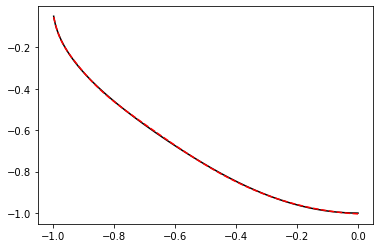

In [17]:
deg=40
coeff=np.polyfit(z,f,deg=deg)

z_poly=z[:,None]**(deg-np.arange(deg+1)[None,:])
f_lda=np.einsum('k,ak->a',coeff,z_poly)

plt.plot(z,f,color='black')
plt.plot(z,f_lda,linestyle='--',color='red')
plt.show()



def f_lda(z:np.ndarray,coeff:np.ndarray):
    
    z_poly=z[:,:,None]**(deg-np.arange(deg+1)[None,None,:])
    
    return np.einsum('k,ijk->ij',coeff,z_poly)
    
    

#### Test in the disorder Case

(200, 8)
(200, 9)
(200, 10)
(200, 11)
(200, 12)
(200, 13)
(200, 14)
(200, 15)
(200, 16)
(200, 17)
(200, 18)
(200, 19)
(200, 20)
(200, 21)
(200, 22)
(200, 23)
(200, 24)
(200, 25)
(200, 26)
(200, 27)
(200, 28)
(200, 29)
(200, 30)
(200, 31)
(200, 32)
(200, 33)
(200, 34)
(200, 35)
(200, 36)
(200, 37)
(200, 38)
(200, 39)
(200, 40)
(200, 41)
(200, 42)
(200, 43)
(200, 44)
(200, 45)
(200, 46)
(200, 47)
(200, 48)
(200, 49)
(200, 50)
(200, 51)
(200, 52)
(200, 53)
(200, 54)
(200, 55)
(200, 56)
(200, 57)
(200, 58)
(200, 59)
(200, 60)
(200, 61)
(200, 62)
(200, 63)
(200, 64)


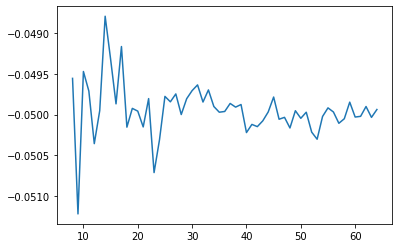

In [20]:
err=[]
ls=np.arange(8,65)
for l in ls:

    data=np.load(f'data/dataset_1nn/field2density_221122/valid_unet_periodic_{l}_l_2.7_h_200_n.npz')
    z=data['density']
    f=data['density_F']
    h=data['potential']
    
    eng=f+z*h
    f_ml=f_lda(z,coeff)
    print(f_ml.shape)

    err.append(np.average(np.average(np.abs(f_ml-f),axis=-1)/np.average(eng,axis=-1)))

plt.plot(ls,err)
plt.show()






#### Consider the LDA in the z_ave f_ave condition